# 0.0 Overview

Code hiding script from [Damian Kao](http://blog.nextgenetics.net/?e=102).

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Code hidden for easier reading: <a href="javascript:code_toggle()">toggle on/off.</a>''')

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
from research.strings import TARGET, PREDICTORS, INSPECTORS, OTHER_PREDICTORS
from research.evaluation import evaluate_model
from research.metrics import show_metrics, compare_metrics, to_inspection_daynum

## Data

Distribution of train and test data.

In [4]:
d_details = pd.read_csv("data/inspections.csv")
d_train = pd.read_csv("data/train_data.csv")
d_test = pd.read_csv("data/test_data.csv")
X_train = d_train[PREDICTORS]
X_test = d_test[PREDICTORS]
y_train = d_train[TARGET]
y_test = d_test[TARGET]
print("Train: N = {0}, P(CriticalFound|X) = {1:.3f}".format(len(X_train), y_train.mean()))
print("Test:  N = {0}, P(CriticalFound|X) = {1:.3f}".format(len(X_test), y_test.mean()))

Train: N = 17075, P(CriticalFound|X) = 0.141
Test:  N = 1637, P(CriticalFound|X) = 0.158


## Correlation Matrix

Correlation matrix of target and predictor variables.

In [5]:
d_train[[TARGET] + PREDICTORS].corr().round(3)

,criticalFound,Inspector_blue,Inspector_brown,Inspector_green,Inspector_orange,Inspector_purple,Inspector_yellow,pastSerious,pastCritical,timeSinceLast,ageAtInspection,consumption_on_premises_incidental_activity,tobacco_retail_over_counter,temperatureMax,heat_burglary,heat_sanitation,heat_garbage
criticalFound,1.000,0.162,-0.117,-0.079,-0.007,0.208,-0.105,0.040,0.051,0.017,-0.021,0.058,0.016,0.032,0.044,0.032,-0.021
Inspector_blue,0.162,1.000,-0.159,-0.274,-0.241,-0.123,-0.199,0.022,0.044,0.018,-0.015,0.008,0.046,-0.007,0.075,0.102,0.084
Inspector_brown,-0.117,-0.159,1.000,-0.213,-0.187,-0.096,-0.154,-0.004,-0.030,0.011,-0.001,-0.050,0.017,0.011,-0.055,-0.045,0.189
Inspector_green,-0.079,-0.274,-0.213,1.000,-0.323,-0.165,-0.267,-0.003,0.010,0.038,-0.002,0.054,-0.043,-0.004,0.005,0.012,-0.124
Inspector_orange,-0.007,-0.241,-0.187,-0.323,1.000,-0.145,-0.234,-0.028,-0.048,-0.020,0.024,-0.030,0.022,0.010,-0.033,-0.086,0.040
Inspector_purple,0.208,-0.123,-0.096,-0.165,-0.145,1.000,-0.119,0.006,0.008,0.037,0.002,0.028,-0.025,0.028,0.049,0.016,-0.108
Inspector_yellow,-0.105,-0.199,-0.154,-0.267,-0.234,-0.119,1.000,0.012,0.017,-0.075,-0.011,-0.017,-0.018,-0.028,-0.032,0.007,-0.068
pastSerious,0.040,0.022,-0.004,-0.003,-0.028,0.006,0.012,1.000,0.326,-0.327,0.053,0.033,-0.027,-0.072,0.031,0.034,0.022
pastCritical,0.051,0.044,-0.030,0.010,-0.048,0.008,0.017,0.326,1.000,-0.251,0.044,0.023,-0.035,-0.055,0.014,0.023,-0.006
timeSinceLast,0.017,0.018,0.011,0.038,-0.020,0.037,-0.075,-0.327,-0.251,1.000,-0.124,-0.043,0.126,0.171,0.060,0.053,0.049


## Traditional Metrics

Evaluation of City model based on traditional confusion matrix metrics.

In [6]:
clf = pickle.load(open("models/sklearn-glm.pkl", "rb"))
evaluate_model(y_test, clf.predict(X_test))

F1 Score = 0.08664
Precision = 0.63158
Recall = 0.04651


,Predicted +,Predicted -
Actual +,12,246
Actual -,7,1372


## Performance Metrics

Evaluation of City model based on project metrics.

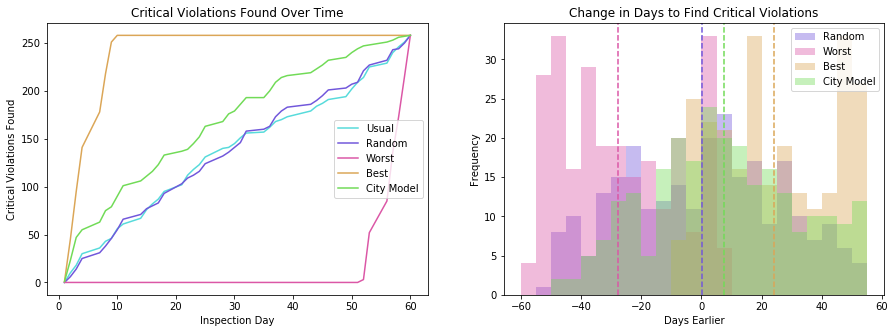

,Model,First Half,Mean Change,Std. Change
3,Best,1.000,24.058,19.390
4,City Model,0.690,7.438,25.156
0,Usual,0.554,0.000,0.000
1,Random,0.531,0.236,26.436
2,Worst,0.000,-27.659,19.049


In [7]:
y_true = y_test.copy()
days = to_inspection_daynum(d_test["Inspection_Date"])
np.random.seed(0)
base_models = [
    ("Usual", days.max() - days),
    ("Random", np.random.rand(len(y_true))),
    ("Worst", 1 - y_true),
    ("Best", y_true)
]
y_scores = clf.predict_proba(X_test)[:,1]
models = [
    ("City Model", y_scores)
]
all_models = base_models + models
compare_metrics(y_true, days, all_models)

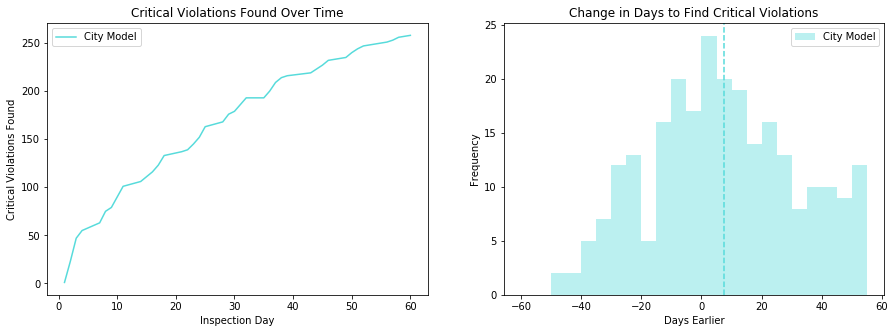

,Model,First Half,Mean Change,Std. Change
0,City Model,0.69,7.438,25.156


In [8]:
show_metrics(y_true, days, y_scores, name="City Model")

## Sanitarian Clusters

Sanitarian clusters in City model.

In [9]:
# Select only the training data
df = d_details.query("Inspection_Date < 16252")
ins_sum = pd.DataFrame(
    clf.coef_[0][:,0][0:len(INSPECTORS)],
    INSPECTORS, columns=["Coefficient"]
)
df_ins = pd.DataFrame(df)
df_ins["Inspector"] = df[INSPECTORS].idxmax(axis=1).apply(lambda x: str(x)[10:])
ins_sum["Count"] = df_ins.groupby(["Inspector"]).size().values
ins_sum["Proportion"] = ins_sum["Count"] / len(df_ins)
ins_sum["Hit Rate"] = df_ins.groupby(["Inspector"])[TARGET].mean().values
ins_sum.round(3).sort_values(by="Coefficient", ascending=False)

,Coefficient,Count,Proportion,Hit Rate
Inspector_purple,1.555,1174,0.069,0.406
Inspector_blue,0.950,2897,0.170,0.265
Inspector_orange,0.202,3769,0.221,0.136
Inspector_green,-0.244,4595,0.269,0.095
Inspector_yellow,-0.697,2762,0.162,0.058
Inspector_brown,-1.306,1878,0.110,0.024


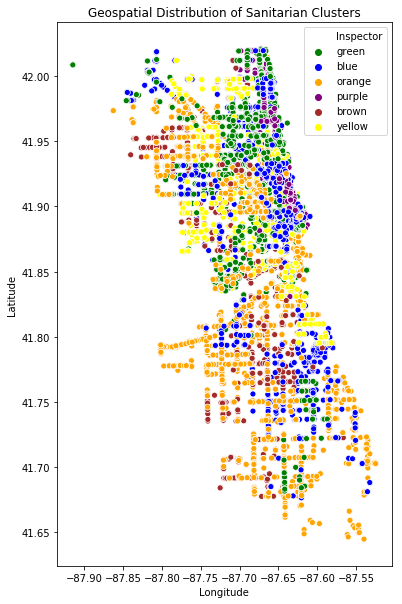

In [10]:
sns.scatterplot(
    x="longitude", y="latitude",
    hue=df_ins["Inspector"], data=df,
    palette=["green", "blue", "orange", "purple", "brown", "yellow"]
).figure.set_size_inches(6, 10)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geospatial Distribution of Sanitarian Clusters")
plt.show()